In [7]:
# Core Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
import pandas as pd
import os

# Check if CSV file exists
csv_path = "Labels.csv"
if not os.path.exists(csv_path):
    print(f"Error: {csv_path} not found in current directory")
    print(f"Current directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    print(f"Found CSV file: {csv_path}")

# Load and clean CSV
df = pd.read_csv("Labels.csv")
print(f"CSV loaded with {len(df)} rows")

# Strip spaces and fix column names
df.columns = df.columns.str.strip()
df["Label"] = df["Label"].str.strip().str.upper()

print(f"Columns: {list(df.columns)}")
print(f"Unique labels: {df['Label'].unique()}")

# Map labels: GON+ → 1 (Glaucoma), GON- → 0 (Normal)
label_map = {"GON+": 1, "GON-": 0}
df = df[df["Label"].isin(label_map.keys())]  # Filter unexpected values
df["label"] = df["Label"].map(label_map)

print(f"After filtering: {len(df)} rows")

# Check if Images directory exists
image_dir = "Images"
if not os.path.exists(image_dir):
    print(f"Error: {image_dir} directory not found in current directory")
    print(f"Available directories: {[d for d in os.listdir('.') if os.path.isdir(d)]}")
else:
    print(f"Found Images directory with {len(os.listdir(image_dir))} files")

# Create list of (image_path, label)
image_label_list = []
missing_files = []

for fname, label in zip(df["Image Name"], df["label"]):
    img_path = os.path.join(image_dir, fname)
    if os.path.exists(img_path):
        image_label_list.append((img_path, label))
    else:
        missing_files.append(fname)

print(f"Total labeled images found: {len(image_label_list)}")
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print(f"First 5 missing files: {missing_files[:5]}")

Found CSV file: Labels.csv
CSV loaded with 747 rows
Columns: ['Image Name', 'Patient', 'Label', 'Quality Score', 'Unnamed: 4']
Unique labels: ['GON+' 'GON-']
After filtering: 747 rows
Found Images directory with 747 files
Total labeled images found: 747
Missing files: 0


In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Check if image_label_list exists and is not empty
if 'image_label_list' not in globals():
    print("Error: image_label_list not found. Please run the previous cell first.")
    raise NameError("image_label_list is not defined. Run the previous cell first.")
elif len(image_label_list) == 0:
    print("Error: image_label_list is empty. Check if Images folder and Labels.csv are properly set up.")
    raise ValueError("image_label_list is empty")
else:
    print(f"Using {len(image_label_list)} images for splitting")

# Stratified train-val-test split
# First split: separate test set from the rest
train_val_split, test_split = train_test_split(
    image_label_list,
    test_size=0.1,  # 10% for test
    stratify=[label for _, label in image_label_list],
    random_state=42
)

# Second split: separate train and val from remaining data
train_split, val_split = train_test_split(
    train_val_split,
    test_size=0.2,  # 20% of remaining for validation
    stratify=[label for _, label in train_val_split],
    random_state=42
)

print(f"Train samples: {len(train_split)}, Val samples: {len(val_split)}, Test samples: {len(test_split)}")

# Save split information to CSV files
import pandas as pd

# Create DataFrames for train, val, and test splits
train_df = pd.DataFrame(train_split, columns=['image_path', 'label'])
val_df = pd.DataFrame(val_split, columns=['image_path', 'label'])
test_df = pd.DataFrame(test_split, columns=['image_path', 'label'])

# Save to CSV files
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print(f"Saved train split to train_split.csv ({len(train_df)} images)")
print(f"Saved val split to val_split.csv ({len(val_df)} images)")
print(f"Saved test split to test_split.csv ({len(test_df)} images)")

# Custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

Using 747 images for splitting
Train samples: 537, Val samples: 135, Test samples: 75
Saved train split to train_split.csv (537 images)
Saved val split to val_split.csv (135 images)
Saved test split to test_split.csv (75 images)


In [10]:
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = GlaucomaDataset(train_split, transform=train_transform)
val_dataset = GlaucomaDataset(val_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [11]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load EfficientNet with pretrained weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace final classification layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Push model to device
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCHS = 100
PATIENCE = 7

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds, epoch_val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            break

model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")

Epoch 1/100: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]



Epoch 1: Train Loss = 0.5505, Train Acc = 77.28% | Val Loss = 0.4507, Val Acc = 77.04%


Epoch 2/100: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]



Epoch 2: Train Loss = 0.2954, Train Acc = 92.18% | Val Loss = 0.2309, Val Acc = 94.07%


Epoch 3/100: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]



Epoch 3: Train Loss = 0.1814, Train Acc = 95.53% | Val Loss = 0.1816, Val Acc = 97.04%


Epoch 4/100: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]



Epoch 4: Train Loss = 0.1353, Train Acc = 95.72% | Val Loss = 0.1651, Val Acc = 96.30%


Epoch 5/100: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]



Epoch 5: Train Loss = 0.0855, Train Acc = 97.58% | Val Loss = 0.1238, Val Acc = 96.30%


Epoch 6/100: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]



Epoch 6: Train Loss = 0.0749, Train Acc = 97.95% | Val Loss = 0.1222, Val Acc = 97.04%


Epoch 7/100: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]



Epoch 7: Train Loss = 0.0579, Train Acc = 98.32% | Val Loss = 0.1174, Val Acc = 97.78%


Epoch 8/100: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]



Epoch 8: Train Loss = 0.0448, Train Acc = 98.88% | Val Loss = 0.1424, Val Acc = 97.78%


Epoch 9/100: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]



Epoch 9: Train Loss = 0.0446, Train Acc = 98.32% | Val Loss = 0.1723, Val Acc = 97.78%


Epoch 10/100: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]



Epoch 10: Train Loss = 0.0264, Train Acc = 99.63% | Val Loss = 0.1776, Val Acc = 97.78%


Epoch 11/100: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]



Epoch 11: Train Loss = 0.0534, Train Acc = 98.14% | Val Loss = 0.1367, Val Acc = 97.78%


Epoch 12/100: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]



Epoch 12: Train Loss = 0.0298, Train Acc = 99.26% | Val Loss = 0.1990, Val Acc = 97.78%


Epoch 13/100: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]



Epoch 13: Train Loss = 0.0190, Train Acc = 99.81% | Val Loss = 0.1959, Val Acc = 97.78%


Epoch 14/100: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]



Epoch 14: Train Loss = 0.0211, Train Acc = 99.63% | Val Loss = 0.2577, Val Acc = 97.78%


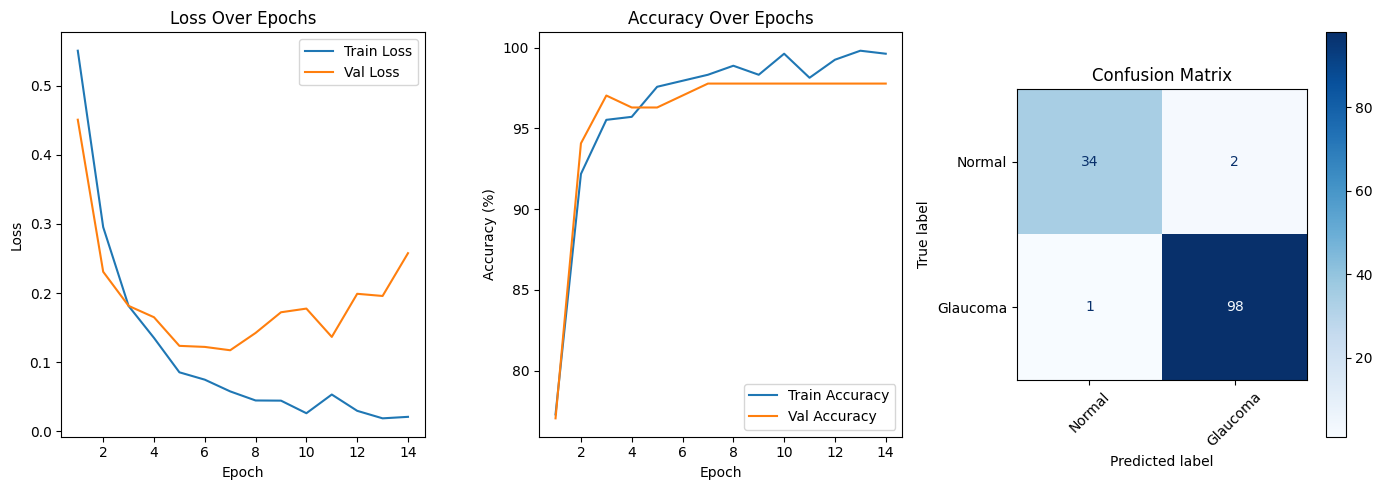

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion matrix from last epoch
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_val_labels_by_epoch[-1], all_val_preds_by_epoch[-1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("glaucoma_results.png")
plt.show()

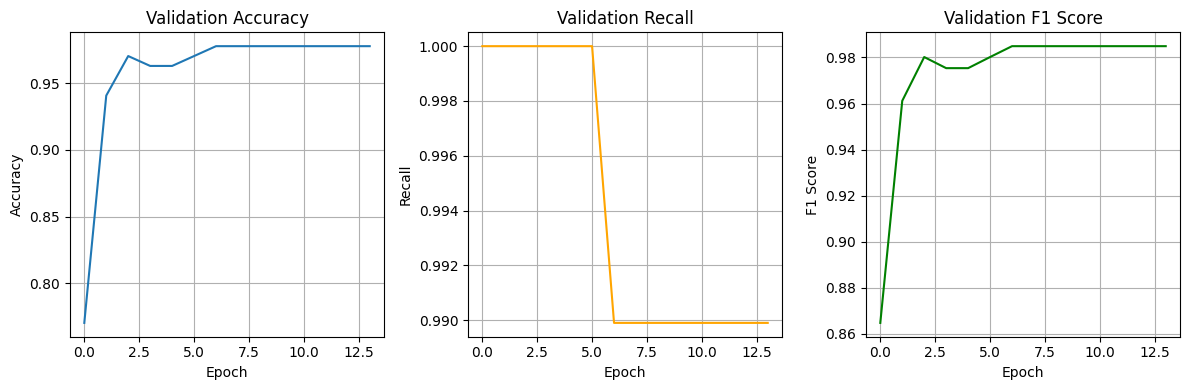

In [14]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for preds, labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(labels, preds))
    val_metrics["recall"].append(recall_score(labels, preds))
    val_metrics["f1_score"].append(f1_score(labels, preds))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_metrics["recall"], label="Recall", color="orange")
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluating on test set...


Testing: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


=== FINAL TEST SET RESULTS ===
Test Accuracy: 0.9733 (97.33%)
Test Precision: 0.9733
Test Recall: 0.9733
Test F1-Score: 0.9733

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95        20
    Glaucoma       0.98      0.98      0.98        55

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



<Figure size 800x600 with 0 Axes>

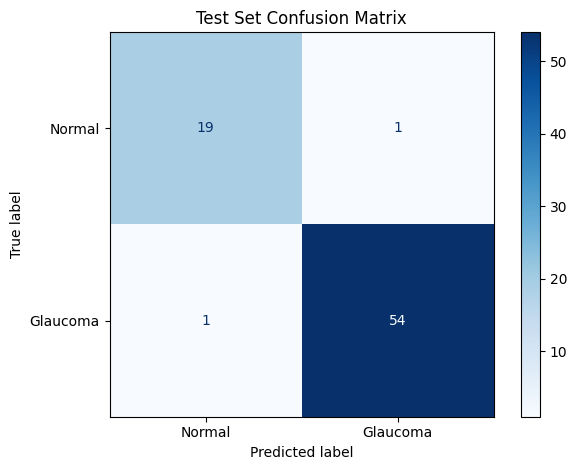

In [15]:
# Test Set Evaluation
print("Evaluating on test set...")

# Create test dataset and loader
test_dataset = GlaucomaDataset(test_split, transform=val_transform)  # Use same transform as validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Evaluate on test set
model.eval()
test_correct, test_total = 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total

# Calculate test metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"\n=== FINAL TEST SET RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_acc:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Normal", "Glaucoma"]))

# Test confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(test_labels, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normal", "Glaucoma"])
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.savefig("test_confusion_matrix.png")
plt.show()

=== MODEL PERFORMANCE SUMMARY ===

Performance Summary:
Dataset      Accuracy   Recall     F1-Score  
---------------------------------------------
Training     0.9963     -          -         
Validation   0.9778     0.9899     0.9849    
Test         0.9733     0.9733     0.9733    

Summary saved to model_performance_summary.csv


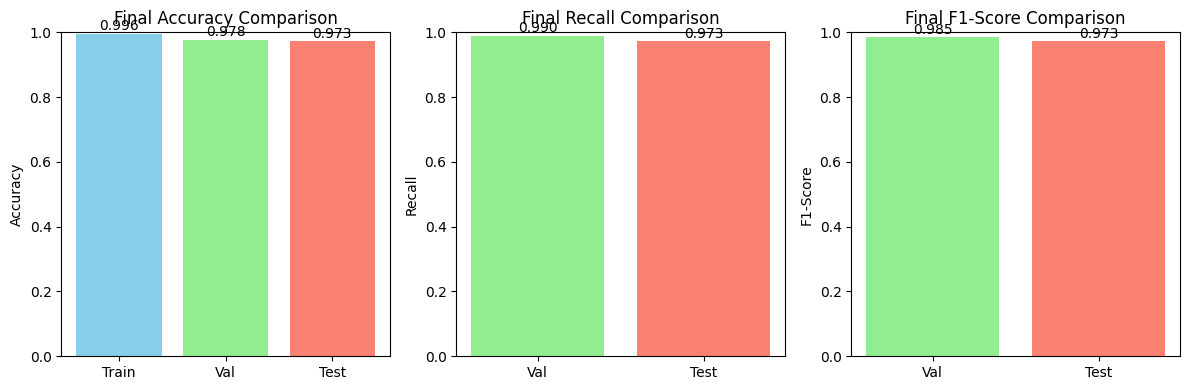

In [16]:
# Summary Comparison: Train vs Validation vs Test
print("=== MODEL PERFORMANCE SUMMARY ===")

# Get final training metrics (last epoch)
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]

# Get final validation metrics
final_val_accuracy = val_metrics["accuracy"][-1]
final_val_recall = val_metrics["recall"][-1]
final_val_f1 = val_metrics["f1_score"][-1]

# Create summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [final_train_acc/100, final_val_accuracy, test_accuracy],
    'Recall': ['-', final_val_recall, test_recall],
    'F1-Score': ['-', final_val_f1, test_f1]
}

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")

# Format and print the table manually to avoid pandas formatting issues
print(f"{'Dataset':<12} {'Accuracy':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 45)
for idx, row in summary_df.iterrows():
    dataset = row['Dataset']
    accuracy = f"{row['Accuracy']:.4f}" if isinstance(row['Accuracy'], (int, float)) else row['Accuracy']
    recall = f"{row['Recall']:.4f}" if isinstance(row['Recall'], (int, float)) else row['Recall']
    f1_score = f"{row['F1-Score']:.4f}" if isinstance(row['F1-Score'], (int, float)) else row['F1-Score']
    print(f"{dataset:<12} {accuracy:<10} {recall:<10} {f1_score:<10}")

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print(f"\nSummary saved to model_performance_summary.csv")

# Plot final comparison
plt.figure(figsize=(12, 4))

# Accuracy comparison
plt.subplot(1, 3, 1)
datasets = ['Train', 'Val', 'Test']
accuracies = [final_train_acc/100, final_val_accuracy, test_accuracy]
bars1 = plt.bar(datasets, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Recall comparison
plt.subplot(1, 3, 2)
recall_vals = [final_val_recall, test_recall]
bars2 = plt.bar(['Val', 'Test'], recall_vals, color=['lightgreen', 'salmon'])
plt.title('Final Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
for i, v in enumerate(recall_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-Score comparison
plt.subplot(1, 3, 3)
f1_vals = [final_val_f1, test_f1]
bars3 = plt.bar(['Val', 'Test'], f1_vals, color=['lightgreen', 'salmon'])
plt.title('Final F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('final_performance_comparison.png')
plt.show()